In [23]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math
from typing import List, Tuple, Dict, Any, Union
import scipy
import random
from functools import reduce

from qiskit import transpile
from qiskit_aer import AerSimulator  # as of 25Mar2025
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT, UnitaryGate, PhaseGate, RZGate
from qiskit.quantum_info import Operator
from sympy import latex, Matrix # for latex display
from IPython.display import display, Math
from qiskit.quantum_info import Pauli, SparsePauliOp, Operator



# import basic plot tools
from qiskit.visualization import plot_histogram

from algos import *

In [24]:
def standard_qpe(unitary: Operator, eigenstate: QuantumCircuit, num_ancilla: int) -> QuantumCircuit:
    """Constructs a standard Quantum Phase Estimation (QPE) circuit using repeated controlled-U applications."""
    num_qubits = unitary.num_qubits
    qc = QuantumCircuit(num_ancilla + num_qubits, num_ancilla)

    # Prepare eigenstate on system qubits
    qc.append(eigenstate, range(num_ancilla, num_ancilla + num_qubits))

    # Apply Hadamard gates to ancilla qubits
    qc.h(range(num_ancilla))

    # Apply controlled-U^(2^k) using repeated controlled applications of U
    for k in range(num_ancilla):
        controlled_U = UnitaryGate(unitary.data).control(1, label=f"U")
        
        # Apply controlled-U 2^k times
        for _ in range(2**k):  
            qc.append(controlled_U, [k] + list(range(num_ancilla, num_ancilla + num_qubits)))

    # Apply inverse QFT on ancilla qubits
    qc.append(QFT(num_ancilla, inverse=True, do_swaps=True), range(num_ancilla))

    # Measure ancilla qubits
    qc.measure(range(num_ancilla), range(num_ancilla))

    return qc

SANITY CHECK:

$$ U = \begin{pmatrix}
                    1 & 0 \\
                    0 & e^{i\theta}
                \end{pmatrix} $$

So, for $|\lambda \rangle = |1\rangle$  we have $U |1\rangle = e^{i\theta} |1\rangle$ 

In happy cases, we have $ \theta = \frac{2 \pi k}{2^n} $ where $k$ is an integer and $n$ is the number of ancilla qubits and the number read in the ancila register willbe exactly $k$.

Experiments:
Let n = 3, so we have 3 ancilla qubits. The possible values of $k$ are $0, 1, 2, 3, 4, 5, 6, 7$.
- $k = 1 \implies \theta = \frac{2 \pi}{8} = \frac{\pi}{4}$
- $k = 2 \implies \theta = \frac{4 \pi}{8} = \frac{\pi}{2}$
- $k = 3 \implies \theta = \frac{6 \pi}{8} = \frac{3\pi}{4}$
- $k = 4 \implies \theta = \frac{8 \pi}{8} = \pi$
- $k = 5 \implies \theta = \frac{10 \pi}{8} = \frac{5\pi}{4}$
- $k = 6 \implies \theta = \frac{12 \pi}{8} = \frac{3\pi}{2}$
- $k = 7 \implies \theta = \frac{14 \pi}{8} = \frac{7\pi}{4}$
...

In [25]:
def test_general_qpe_with_parametrized_phase(phase, expected_bin):
    unitary = Operator(PhaseGate(phase))
    
    eigenstate = QuantumCircuit(1)
    eigenstate.x(0)

    num_ancilla = 3
    shots = 1024
    qc = standard_qpe(unitary, eigenstate, num_ancilla)

    simulator = AerSimulator()
    job = simulator.run(transpile(qc, simulator), shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    most_probable = max(counts, key=counts.get)
    assert most_probable.startswith(expected_bin), f"Expected prefix {expected_bin}, got {most_probable}"

    plot_histogram(counts).savefig(f"output_general_phase_{round(phase, 3)}.png")

easy_test_cases = [np.pi/4, np.pi/2, 3*np.pi/4]
for phase in easy_test_cases:
    U = Operator(PhaseGate(phase))
    eigenstate = QuantumCircuit(1)
    eigenstate.x(0)
    num_ancilla = 3
    shots = 1024
    qc = standard_qpe(U, eigenstate, num_ancilla)
    qc.draw("mpl").savefig(f"circuit_general_phase_{round(phase, 3)}.png")

    simulator = AerSimulator()
    job = simulator.run(transpile(qc, simulator), shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    most_probable = max(counts, key=counts.get)
    print(f"Most probable outcome for phase {phase}: {most_probable}")
    print("Estimated phase:", math.pi * 2 * int(most_probable, 2) / (2**3))

Most probable outcome for phase 0.7853981633974483: 001
Estimated phase: 0.7853981633974483
Most probable outcome for phase 1.5707963267948966: 010
Estimated phase: 1.5707963267948966
Most probable outcome for phase 2.356194490192345: 011
Estimated phase: 2.356194490192345


## Real test: estimating eigenvalues of a Hermitian matrix

Let $H$ be a Hermitian matrix. We can use the quantum phase estimation algorithm to estimate the eigenvalues of $H$.

Since $H$ is Hermitian, then $e^{iHt}$ is unitary, so we can apply QPE to it. Let $|\lambda\rangle$ be an eigenvector of $H$ with eigenvalue $\lambda$.

Then $$e^{iHt}|\lambda\rangle = e^{i\lambda t}|\lambda\rangle$$

But since we initially get the phase $\varphi$, rather than $\lambda$ directly, we must re-write as:

$$e^{i\lambda t}|\lambda\rangle = e^{2 \pi i \varphi}|\lambda\rangle$$

where $$ \varphi = \frac{\lambda t}{2 \pi} \iff \lambda = \frac{2 \pi \varphi}{t}$$

But (again) we really only $\textit{estimate}$ up to a "best t-bit approximation" $\tilde{\varphi}$ of $\varphi$ as $\frac{m}{2^t}$, where $m$ is the integer that minimizes $|\varphi - \frac{m}{2^t}|$

In [26]:
# Type aliases
coefficient = float
Hamiltonian = list[tuple[coefficient, Pauli]]

def format_hamiltonian_matrix_as_latex(matrix: np.ndarray):
    """Formats a matrix as LaTeX."""
    sympy_matrix = Matrix(matrix)
    return latex(sympy_matrix)

# example for 2 qubits
H = generate_ising_hamiltonian(2, 1.2, 1)
H_nice_format = format_hamiltonian_matrix_as_latex(H)
display(Math(H_nice_format))

<IPython.core.display.Math object>

In [ ]:
import numpy as np
import scipy.linalg
from qiskit.quantum_info import SparsePauliOp, Operator, Pauli
from qiskit.circuit import QuantumCircuit, Gate
from sympy import symbols, I, exp, latex, simplify, Matrix
from IPython.display import display, Math


def pauli_term_to_tensor_product(pauli_str: str) -> str:
    """
    Converts a Pauli string (e.g., 'XI') to an explicit tensor product representation.
    """
    pauli_symbols = {
        'I': symbols('I'),
        'X': symbols('X'),
        'Y': symbols('Y'),
        'Z': symbols('Z')
    }
    
    # Construct the tensor product explicitly
    term_expr = []
    for char in pauli_str:
        term_expr.append(pauli_symbols[char])
    
    # Format as tensor product
    tensor_expr = ' \\otimes '.join([latex(term) for term in term_expr])
    
    return tensor_expr


def pauli_term_to_simplified(pauli_str: str) -> str:
    """
    Converts a Pauli string (e.g., 'XI') to a simplified symbolic form.
    """
    pauli_symbols = {
        'I': symbols('I'),
        'X': symbols('X'),
        'Y': symbols('Y'),
        'Z': symbols('Z')
    }
    
    # Construct the product expression (compact form)
    term_expr = 1
    for char in pauli_str:
        term_expr *= pauli_symbols[char]
    
    return term_expr


def hamiltonian_explicit(H: SparsePauliOp) -> str:
    """
    Construct the Hamiltonian with full tensor product notation.
    """
    pauli_terms = H.to_list()
    explicit_terms = []

    for pauli_str, coeff in pauli_terms:
        tensor_product = pauli_term_to_tensor_product(pauli_str)
        # Construct the term explicitly
        term_expr = f"{latex(coeff)} \\cdot {tensor_product}"
        explicit_terms.append(term_expr)
    
    # Join all terms into a single LaTeX string
    explicit_hamiltonian = ' + '.join(explicit_terms)
    return explicit_hamiltonian


def hamiltonian_simplified(H: SparsePauliOp) -> str:
    """
    Construct the Hamiltonian in a simplified symbolic form.
    """
    pauli_terms = H.to_list()
    H_sym = 0

    for pauli_str, coeff in pauli_terms:
        # Construct each term in simplified form
        term_expr = coeff * pauli_term_to_simplified(pauli_str)
        H_sym += term_expr
    
    # Simplify the expression to make it more readable
    H_sym = simplify(H_sym)
    
    # Return the LaTeX string representation
    return latex(H_sym)

def format_hamiltonian_matrix_as_latex(matrix: np.ndarray):
    """Formats a matrix as LaTeX."""
    sympy_matrix = Matrix(matrix)
    return latex(sympy_matrix)

def display_hamiltonian(H: SparsePauliOp):
    """Display both the explicit tensor product form and the simplified form of the Hamiltonian."""
    
    # Explicit tensor product form
    explicit_latex = hamiltonian_explicit(H)
    display(Math(f"H = {explicit_latex}"))
    
    # Simplified form
    simplified_latex = hamiltonian_simplified(H)
    display(Math(f"H = {simplified_latex}"))

    # matrx representation
    matrix = H.to_matrix()
    matrix_latex = format_hamiltonian_matrix_as_latex(matrix)
    display(Math(f"H = {matrix_latex}"))


# Example Usage:
num_qubits = 2
J = 1.0
g = 0.5
time = 1.0

# Generate Hamiltonian
H = generate_ising_hamiltonian(num_qubits, J, g)

# Display the Hamiltonian as a sum of Pauli terms
display_hamiltonian(H)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
# Function to generate a random Hamiltonian
def generate_random_hamiltonian(num_qubits, num_terms) -> Hamiltonian:
    pauli_matrices = [Pauli('X'), Pauli('Z'), Pauli('I')]
    hamiltonian_terms = []
    for _ in range(num_terms):
        pauli_string = reduce(lambda x, y: x.tensor(y), random.choices(pauli_matrices, k=num_qubits))
        hamiltonian_terms.append((random.uniform(0, 1), pauli_string)) # The first element is the coefficient
    return hamiltonian_terms


def construct_hamiltonian(hamiltonian_terms: Hamiltonian) -> SparsePauliOp:
    """Constructs the full Hamiltonian as a SparsePauliOp."""
    return SparsePauliOp([term[1] for term in hamiltonian_terms], coeffs=[term[0] for term in hamiltonian_terms])


H_terms = generate_random_hamiltonian(2, 4)
H = construct_hamiltonian(H_terms)

H_nice_format = format_hamiltonian_matrix_as_latex(H.to_matrix())
display(Math(H_nice_format))

<IPython.core.display.Math object>

In [ ]:
# calculate the eigenvalues of the Hamiltonian

ground_state, ground_energy = calculate_ground_state_and_energy(H)
print("Ground state:", ground_state)
print("Ground energy:", ground_energy)

Ground state: [ 0.12008785-0.j  0.69683492+0.j -0.69683492-0.j -0.12008785-0.j]
Ground energy: (-0.5622706803132299+0j)


In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import Initialize
from qiskit.quantum_info import Statevector
import numpy as np

def prepare_ground_state_circuit(ground_state: np.ndarray) -> QuantumCircuit:
    """
    Prepare a quantum circuit that initializes the ground state.
    
    Args:
        ground_state (np.ndarray): State vector representing the ground state.

    Returns:
        QuantumCircuit: Circuit that prepares the ground state.
    """
    num_qubits = int(np.log2(len(ground_state)))
    if 2 ** num_qubits != len(ground_state):
        raise ValueError("The length of the state vector must be a power of 2.")

    # Normalize the state vector
    ground_state = ground_state / np.linalg.norm(ground_state)

    # Initialize circuit
    qc = QuantumCircuit(num_qubits)
    init_gate = Initialize(ground_state)
    qc.append(init_gate, range(num_qubits))

    # Optional: Simplify the circuit using transpile
    # from qiskit import transpile
    # qc = transpile(qc, optimization_level=3)

    qc.barrier()
    return qc

In [ ]:

# Function to sample unitaries from the qDRIFT distribution
def qdrift_sample(hamiltonian_terms: list[tuple[coefficient, Pauli]], time, num_samples) -> tuple[list[Operator], list[str]]:
    lam = sum(abs(term[0]) for term in hamiltonian_terms)
    tau = time  * lam / num_samples
    sampled_unitaries = []
    hamiltonian_specific_pmf = [abs(coeff) for coeff, _ in hamiltonian_terms]
    num_terms = len(hamiltonian_terms)
    labels = []
    for _ in range(num_samples):
        j = random.choices(range(num_terms), weights=hamiltonian_specific_pmf, k=1)[0]
        h_j = hamiltonian_terms[j][1]
        v = scipy.linalg.expm(1j * tau * h_j.to_matrix())
        sampled_unitaries.append(v)
        # Format the label as LaTeX
        labels.append(f"$e^{{i\\cdot \\tau \\cdot H_{j}}}$")
    return sampled_unitaries, labels

# Function to construct controlled unitaries
def construct_controlled_unitary(sampled_unitaries, labels):
    controlled_unitaries = []
    for unitary, label in zip(sampled_unitaries, labels):
        controlled_unitary = UnitaryGate(unitary, label=label).control(1)
        controlled_unitaries.append(controlled_unitary)
    return controlled_unitaries

# Function to perform qDRIFT-based QPE
def qdrift_qpe(hamiltonian_terms, time, eigenstate, num_qubits, num_ancilla):
    # Initialize the quantum circuit
    qc = QuantumCircuit(num_ancilla + num_qubits, num_ancilla)
    
    # Prepare the eigenstate on the system qubits
    if isinstance(eigenstate, np.ndarray):
        eigenstate_circuit = QuantumCircuit(num_qubits, name=f'eigenstate')
        eigenstate_circuit.initialize(eigenstate)
    else:
        eigenstate_circuit = eigenstate
    
    qc.append(eigenstate_circuit, range(num_ancilla, num_ancilla + num_qubits))
    
    # Apply QFT to the ancilla qubits
    qc.append(QFT(num_ancilla), range(num_ancilla ))
    
    # Perform controlled qDRIFT unitaries
    for k in range(num_ancilla):
        for _ in range(2**k):
            # Sample unitaries from qDRIFT distribution
            sampled_unitaries, labels = qdrift_sample(hamiltonian_terms=hamiltonian_terms, time=time, num_samples=1)
            # Construct controlled unitaries
            controlled_unitaries = construct_controlled_unitary(sampled_unitaries, labels)
            # Apply controlled unitaries
            for controlled_unitary in controlled_unitaries:
                # apply controlled unitary such that the control qubit is ancilla qubit k
                qc.append(controlled_unitary, [k] + list(range(num_ancilla, num_ancilla + num_qubits)))
    # Apply inverse QFT
    qc.append(QFT(num_ancilla, inverse=True), range(num_ancilla))
    
    # Measure the ancilla qubits
    qc.measure(range(num_ancilla), range(num_ancilla))
    
    return qc


In [ ]:
num_qubits = 2
num_ancilla = 4
time = 1

# Generate Hamiltonian
H_terms = generate_random_hamiltonian(num_qubits=num_qubits, num_terms=4)
H = construct_hamiltonian(H_terms)
print(f"Hamiltonian: {H}")

# Calculate the eigenvalues of the Hamiltonian
ground_state, ground_energy = calculate_ground_state_and_energy(H)
print("Ground state:", ground_state)
print("Ground energy:", ground_energy)
ground_state_circuit = prepare_ground_state_circuit(ground_state)

qc_qdrift_qpe = qdrift_qpe(hamiltonian_terms=H_terms, time=time, eigenstate=ground_state, num_ancilla=num_ancilla, num_qubits=num_qubits)

U = exponentiate_hamiltonian(H, time)
qc_qpe = standard_qpe(U, ground_state_circuit, num_ancilla)

Hamiltonian: SparsePauliOp(['XI', 'IZ', 'IZ', 'XX'],
              coeffs=[0.4666126 +0.j, 0.25641676+0.j, 0.53553633+0.j, 0.33443836+0.j])
Ground state: [ 0.14033414+0.j  0.69304136+0.j -0.14033414+0.j -0.69304136+0.j]
Ground energy: (-1.3262862104468012+0j)


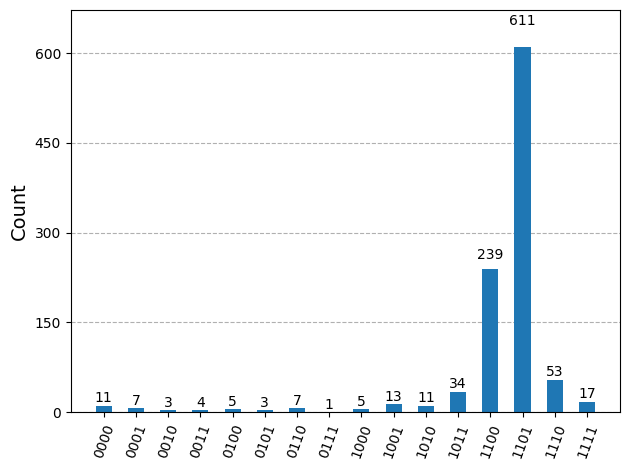

In [ ]:
# test regular QPE first
simulator = AerSimulator()
job = simulator.run(transpile(qc_qpe, simulator), shots=1024)
result = job.result()
counts = result.get_counts(qc_qpe)
plot_histogram(counts)

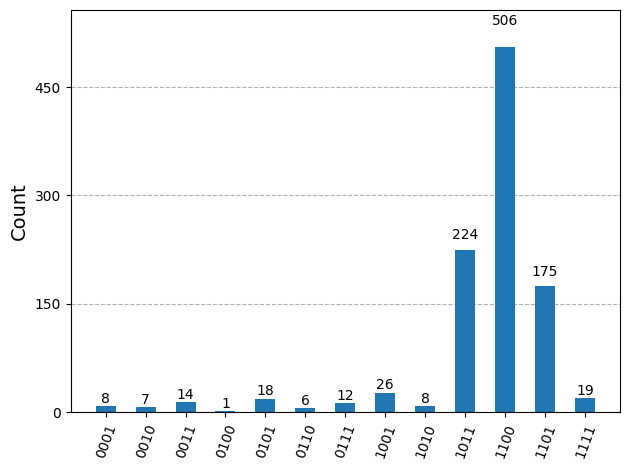

In [ ]:
simulator = AerSimulator()
job = simulator.run(transpile(qc_qdrift_qpe, simulator), shots=1024)
result = job.result()
counts_qdrift = result.get_counts(qc_qdrift_qpe)
plot_histogram(counts_qdrift)


In [ ]:
most_frequent_bitstring = max(counts_qdrift, key=counts_qdrift.get)
print(f"Most frequent bitstring (qdrift):{most_frequent_bitstring} (as int: {int(most_frequent_bitstring, 2)})")
print("Estimated phase:", int(most_frequent_bitstring, 2) / (2**num_ancilla))
print(f"Estimated eigenvalue: {2 * math.pi * int(most_frequent_bitstring, 2) / (2**num_ancilla * time)}")
print(f"Real eigenvalue: {ground_energy}")

Most frequent bitstring (qdrift):1100 (as int: 12)
Estimated phase: 0.75
Estimated eigenvalue: 4.71238898038469
Real eigenvalue: (-1.3262862104468012+0j)


In [ ]:
most_frequent_bitstring = max(counts, key=counts.get)
print(f"Most frequent bitstring (regular QPE):{most_frequent_bitstring} (as int: {int(most_frequent_bitstring, 2)})")
print("Estimated phase:", int(most_frequent_bitstring, 2) / (2**num_ancilla))
print(f"Estimated eigenvalue: {2 * math.pi * int(most_frequent_bitstring, 2) / (2**num_ancilla * time)}")
print(f"Real eigenvalue: {ground_energy}")

Most frequent bitstring (regular QPE):1101 (as int: 13)
Estimated phase: 0.8125
Estimated eigenvalue: 5.105088062083414
Real eigenvalue: (-1.3262862104468012+0j)
